In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-01-18 20:47:33.339322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 20:47:33.339361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [23]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.8

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
#warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]
#warmup_mild = warmup_mild[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [5]:
vax_statuses = [Vax.yes, Vax.no]


In [6]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:

warmup_A_params = {}
warmup_M_params = {}

for vax_status in [status.value for status in vax_statuses]:
                
    
    warmup_A_params[vax_status] = {}
    warmup_A_params[vax_status]['prior'] = []
    warmup_A_params[vax_status]['posterior_init'] = []

    warmup_M_params[vax_status] = {}
    warmup_M_params[vax_status]['prior'] = []
    warmup_M_params[vax_status]['posterior_init'] = []

    for day in range(transition_window):
        warmup_A_params[vax_status]['prior'].append({'loc': warmup_asymp[vax_status][day]/2,
                                                    'scale': warmup_asymp[vax_status][day]/2/10})

        warmup_M_params[vax_status]['prior'].append({'loc': warmup_mild[vax_status][day]/2,
                                                    'scale': warmup_mild[vax_status][day]/2/10})
    

In [8]:
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)

y_train = tf.cast(df.loc[train_start:train_end,'general_ward'], dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'general_ward'], dtype=tf.float32)

2022-01-18 20:47:35.203619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-18 20:47:35.203794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 20:47:35.203830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-18 20:47:35.203857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-18 20:47:35.203883: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:

T_serial = {}
T_serial['prior'] ={'loc':5.8, 'scale':1}


epsilon = {}
epsilon['prior'] ={'a':1, 'b':1}

delta = {}
delta['prior'] ={'a':1, 'b':1}

rho_M = {}
lambda_M = {}
nu_M = {}
rho_G = {}
lambda_G = {}
nu_G = {}

for vax_status in [status.value for status in vax_statuses]:
    
    rho_M[vax_status] = {}
    rho_M[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}


    lambda_M[vax_status] = {}
    lambda_M[vax_status]['prior'] = {'loc': 4.7, 'scale': 1}


    nu_M[vax_status] = {}
    nu_M[vax_status]['prior'] = {'loc': 3.1, 'scale': 1.2}


    rho_G[vax_status] = {}
    rho_G[vax_status]['prior'] = {'a': 31.8, 'b': 10.3}

    lambda_G[vax_status] = {}
    lambda_G[vax_status]['prior'] = {'loc': 3.3, 'scale': 1.0}


    nu_G[vax_status] = {}
    nu_G[vax_status]['prior'] = {'loc': 9.0, 'scale': 0.2}




In [10]:
T_serial_scale = 1.0
delta_scale = 0.2
epsilon_scale = 0.3
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

rho_G_scale = 0.1
lambda_G_scale = 1.0
nu_G_scale = 0.2


In [11]:
T_serial['posterior_init'] = {'loc': tfp.math.softplus_inverse(4.0),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}
delta['posterior_init'] = {'loc':  tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(delta_scale),dtype=tf.float32)}
epsilon['posterior_init'] = {'loc':  tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(epsilon_scale),dtype=tf.float32)}


for vax_status in [status.value for status in vax_statuses]:
    
    rho_M[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

    lambda_M[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.0),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

    nu_M[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(5.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

    rho_G[vax_status]['posterior_init'] = {'loc': tf.cast(np.log(0.1/(1-0.1)),dtype=tf.float32),
                                          'scale':tf.cast(tfp.math.softplus_inverse(rho_G_scale),dtype=tf.float32)}

    lambda_G[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.3),dtype=tf.float32),
                                             'scale':tf.cast(tfp.math.softplus_inverse(lambda_G_scale),dtype=tf.float32)}

    nu_G[vax_status]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(9.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(nu_G_scale),dtype=tf.float32)}

    for day in range(transition_window):
        # must be positive so reverse softplus the mean
        warmup_A_params[vax_status]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(2000.0/100/2),dtype=tf.float32),
                                                             'scale': tf.cast(tfp.math.softplus_inverse(500.0/100/2),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

        warmup_M_params[vax_status]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(1000.0/100/2),dtype=tf.float32),
                                                             'scale': tf.cast(tfp.math.softplus_inverse(100.0/100/2),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G],
                 transition_window,
                T_serial, epsilon, delta, rho_M, lambda_M, nu_M, rho_G, lambda_G, nu_G,
                 warmup_A_params, warmup_M_params, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=tf.reduce_mean(model.call(x_train), axis=-1)

2022-01-18 20:47:45.109484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
model.variables

2022-01-18 20:47:45.207538: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'rho_M_loc_0:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'rho_M_scale_0:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'rho_M_loc_1:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'rho_M_scale_1:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'lambda_M_loc_0:0' shape=() dtype=float32, numpy=2.9489307>,
 <tf.Variable 'lambda_M_scale_0:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'lambda_M_loc_1:0' shape=() dtype=float32, numpy=2.9489307>,
 <tf.Variable 'lambda_M_scale_1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'nu_M_loc_0:0' shape=() dtype=float32, numpy=4.9932394>,
 <tf.Variable 'nu_M_scale_0:0' shape=() dtype=float32, numpy=0.8416177>,
 <tf.Variable 'nu_M_loc_1:0' shape=() dtype=float32, numpy=4.9932394>,
 <tf.Variable 'nu_M_scale_1:0' shape=() dtype=float32, numpy=0.8416177>,
 <tf.Variable 'rho_G_loc_0:0' shape=() dtype=float32, numpy=-2.1972246>,
 <tf.Variable 'rho_G_scale_0:0' shape=() dtype=floa

In [24]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate #beta_1=0.1, beta_2=0.1
)

In [14]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/scale_nicely')

2022-01-18 20:47:45.297884: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-18 20:47:45.297920: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-18 20:47:45.297946: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-18 20:47:45.298180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-01-18 20:47:45.298238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2022-01-18 20:47:45.298252: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [27]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([y_train]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
1/1 [==============================] - 13s 13s/step - loss: 174.9215
Epoch 2/2000


2022-01-19 12:28:01.532111: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-19 12:28:01.532140: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-19 12:28:01.532515: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 174.2655

2022-01-19 12:28:17.257816: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-19 12:28:17.302241: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-01-19 12:28:18.482056: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-01-19 12:28:20.862247: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-19 12:28:25.442670: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/scale_nicely/train/plugins/profile/2022_01_19_12_28_20

2022-01-19 12:28:26.568568: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/scale_nicely/train/plugins/profile/2022_01_19_12_28

1/1 [==============================] - 27s 27s/step - loss: 174.2655
Epoch 3/2000
1/1 [==============================] - 13s 13s/step - loss: 174.8936
Epoch 4/2000
1/1 [==============================] - 13s 13s/step - loss: 175.7238
Epoch 5/2000
1/1 [==============================] - 13s 13s/step - loss: 174.6056
Epoch 6/2000
1/1 [==============================] - 13s 13s/step - loss: 172.9910
Epoch 7/2000
1/1 [==============================] - 13s 13s/step - loss: 172.4135
Epoch 8/2000
1/1 [==============================] - 13s 13s/step - loss: 172.2383
Epoch 9/2000
1/1 [==============================] - 13s 13s/step - loss: 171.8245
Epoch 10/2000
1/1 [==============================] - 13s 13s/step - loss: 170.5937
Epoch 11/2000
1/1 [==============================] - 13s 13s/step - loss: 169.9846
Epoch 12/2000
1/1 [==============================] - 13s 13s/step - loss: 169.8512
Epoch 13/2000
1/1 [==============================] - 13s 13s/step - loss: 169.9855
Epoch 14/2000
1/1 [======

KeyboardInterrupt: 

Text(0.5, 1.0, 'Mild Compartment')

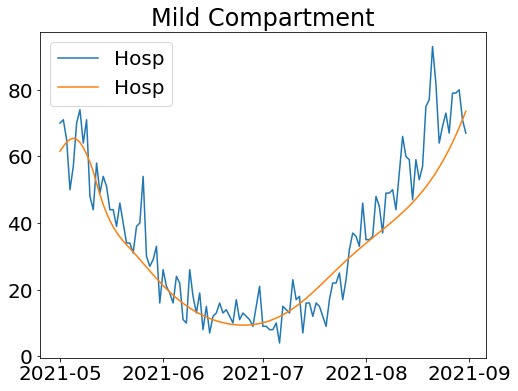

In [28]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='Hosp')
plt.plot(df.loc[train_start:test_end].index.values, preds, label='Hosp')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

Text(0.5, 1.0, 'Mild Compartment')

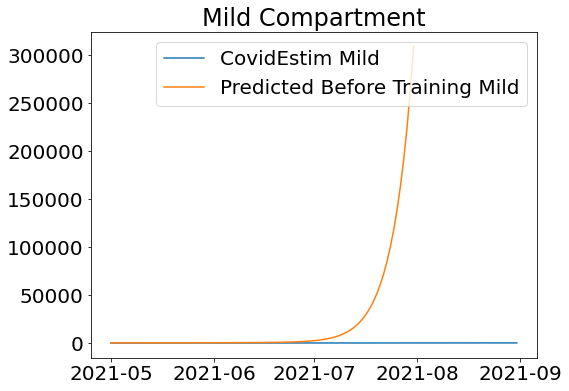

In [20]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:train_end].index.values, pre_training_preds[:len(df.loc[train_start:train_end].index.values)], label='Predicted Before Training Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
pre_training_preds

In [ ]:
preds

In [ ]:
import tfa.optimizers

In [ ]:
0.8*2000

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
y_test

In [ ]:
df.loc[warmup_start:'20210510','mild']

In [ ]:
warmup_start

In [ ]:
warmup_asymp

In [ ]:
import copy

In [ ]:
copy_model = copy.deepcopy(model)
copy_model.unconstrained_warmup_A_params[-1][2]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][1]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_warmup_A_params[-1][0]['loc'] = tf.Variable(2500.0, dtype=tf.float32)
copy_model.unconstrained_nu_M[-1]['loc'] = tf.Variable(3.0, dtype=tf.float32)

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test, label='CovidEstim Mild')
plt.plot(df.loc[train_start:test_end].index.values, copy_preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [ ]:
loss(y_test, copy_model.call(x_train))

In [ ]:
copy_model.unconstrained_nu_M

In [ ]:
copy_model.unconstrained_rho_M[-1]['loc']

In [ ]:
tf.math.sigmoid(1.2)

In [ ]:
warmup_A_params[-1]

In [ ]:
warmup_asymp

In [ ]:
warmup_mild

In [ ]:
1800/2500

In [ ]:
plt.figure(figsize=(8, 6))
copy_preds=tf.reduce_mean(copy_model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end, 'mild']/df.loc[train_start:test_end, 'asymp'], label='Asymp/Mild')
#plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Empirical Rho_M')

In [ ]:
0.96**(1/5.2)

In [ ]:
warmup_asymp

In [ ]:
x_train

In [ ]:
model.T_serial_samples_constrained

In [ ]:
copy_model.call(x_train,return_all=True)

In [ ]:
warmup_asymp*x_train[2] ** (1/model.T_serial_samples_constrained)

In [ ]:
copy_model.warmup_A_samples[1]

In [ ]:
warmup_A

In [ ]:
all_preds = model.call(x_train, return_all=True)

In [ ]:
all_preds[Comp.A.value][1].stack()[:,0]

In [ ]:
warmup_A_params

In [ ]:
tfp.math.softplus_inverse(100.0/1000/2)

In [ ]:
tfp.math.softplus_inverse(4.0)

In [ ]:
model.variables

In [ ]:
model.variables

In [ ]:
model.losses

In [ ]:
model.prior_distros[Comp.M.value][0]['warmup_M'][0].parameters['distribution'].log_prob(6)

In [ ]:
model.prior_distros[Comp.M.value][1]['warmup_M'][0].log_prob(
                model.warmup_M_samples[1][0])+tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[1][0])

In [ ]:
tf.reduce_sum([tf.reduce_sum([-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)]) for status in
                                             model.vax_statuses])

In [ ]:
[tf.reduce_sum([-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)]) for status in
                                             model.vax_statuses]

In [ ]:
[[-tf.reduce_sum(tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1)) for day in range(model.transition_window)] for status in
                                             model.vax_statuses]

In [ ]:
[[-tf.reduce_mean(
            model.prior_distros[Comp.M.value][status.value]['warmup_M'][day].log_prob(
                model.warmup_M_samples[status.value][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[status.value][day])
            - model.warmup_M_probs[status.value][day], axis=-1) for day in range(model.transition_window)] for status in
                                             model.vax_statuses]

In [ ]:
[tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]) + \
            tfp.bijectors.Chain([tfp.bijectors.Softplus(), tfp.bijectors.Scale(100)]).forward_log_det_jacobian(model.warmup_M_samples[0][day])
            - model.warmup_M_probs[0][day], axis=-1) for day in range(model.transition_window)]

In [ ]:
[tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]), axis=-1) for day in range(model.transition_window)]

In [ ]:
model.warmup_M_samples[0][day]

In [ ]:
tf.reduce_mean(
            model.prior_distros[Comp.M.value][0]['warmup_M'][day].log_prob(
                model.warmup_M_samples[0][day]), axis=-1)

In [ ]:
model.prior_distros[Comp.A.value][0]['warmup_A'][0].parameters['distribution'].mean()